In [11]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import numpy as np

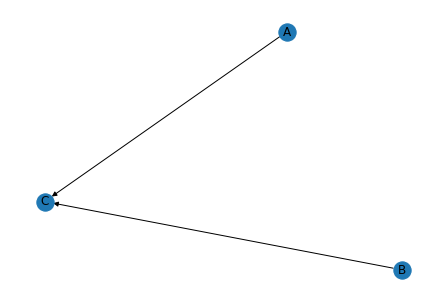

In [4]:
G = nx.DiGraph()
G.add_edge("A", "C")
G.add_edge("B", "C")
nx.draw(G, with_labels=True)

In [6]:
model = BayesianModel(G.edges)

In [7]:
data = pd.DataFrame(data={'A': [0, 0, 1], 'B': [0, 1, 0], 'C': [1, 1, 0]})
data

A  B  C
0  0  0  1
1  0  1  1
2  1  0  0

In [8]:
cpd_C = MaximumLikelihoodEstimator(model, data).estimate_cpd('C')
print(cpd_C)

+------+------+------+------+------+
| A    | A(0) | A(0) | A(1) | A(1) |
+------+------+------+------+------+
| B    | B(0) | B(1) | B(0) | B(1) |
+------+------+------+------+------+
| C(0) | 0.0  | 0.0  | 1.0  | 0.5  |
+------+------+------+------+------+
| C(1) | 1.0  | 1.0  | 0.0  | 0.5  |
+------+------+------+------+------+


This is simply counting the frequencies of the random variables.

$$
\begin{align}
P(C=0 \vert A=0, B=0) &= \frac{\text{Number of obs where C=0, A=0, B=0}}{\text{Number of obs where A=0, B=0}} \\
&= \frac{0}{1} \\
&= 0 \\
\end{align}
$$

$$
\begin{align}
P(C=1 \vert A=0, B=0) &= \frac{\text{Number of obs where C=1, A=0, B=0}}{\text{Number of obs where A=0, B=0}} \\
&= \frac{1}{1} \\
&= 1 \\
\end{align}
$$

And so on. I see that $P(C \vert A=1, B=1)$ is set to $0.5$ and $0.5$, because there are no occurances of $A=1, B=1$ in my dataset and so MLE assumes uniform distribution for all possible values of $C$.



In [13]:
α = np.array([
    [1, 1, 1, 1],
    [2, 2, 2, 2]
])
estimator = BayesianEstimator(model, data)
cpd_C = estimator.estimate_cpd("C", prior_type="dirichlet", pseudo_counts=α)
print(cpd_C)

+------+------+------+------+--------------------+
| A    | A(0) | A(0) | A(1) | A(1)               |
+------+------+------+------+--------------------+
| B    | B(0) | B(1) | B(0) | B(1)               |
+------+------+------+------+--------------------+
| C(0) | 0.25 | 0.25 | 0.5  | 0.3333333333333333 |
+------+------+------+------+--------------------+
| C(1) | 0.75 | 0.75 | 0.5  | 0.6666666666666666 |
+------+------+------+------+--------------------+


Given this is Bayesian learning, the values in the table are really the expected values.

$$
\begin{bmatrix}
1 \rightarrow 1+0 & 1 \rightarrow 1+0 & 1 \rightarrow 1+1 & 1 \rightarrow 1+0 \\
2 \rightarrow 2+1 & 2 \rightarrow 2+1 & 2 \rightarrow 2+0 & 2 \rightarrow 2+0 \\
\end{bmatrix}
$$


So the new values of $\mathbf{\alpha}$ are -

$$
\begin{bmatrix}
{\color{Pink} 1} & {\color{Yellow} 1} & {\color{Cyan} 2} & {\color{Orange} 1} \\
{\color{Pink} 3} & {\color{Yellow} 3} & {\color{Cyan} 2} & {\color{Orange} 2} \\
\end{bmatrix}
$$

And remember each column is a different Beta distribution, so the expected parameter values are -

$$
\begin{bmatrix}
{\color{Pink} {\frac{1}{4}}} & {\color{Yellow} {\frac{1}{4}}} & {\color{Cyan} {\frac{2}{4}}} & {\color{Orange} {\frac{1}{3}}} \\
{\color{Pink} {\frac{3}{4}}} & {\color{Yellow} {\frac{3}{4}}} & {\color{Cyan} {\frac{2}{4}}} & {\color{Orange} {\frac{2}{3}}} \\
\end{bmatrix}
$$

In [45]:
with open("./survey2.txt") as f:
    header = next(f)
    header = header.strip()
    colnames = [fld.strip('"') for fld in header.split(" ")]
    columns = [None] * len(colnames)
    for i in range(len(colnames)):
        columns[i] = []
    for line in f:
        line = line.strip()
        flds = [fld.strip('"') for fld in line.split(" ")]
        for i, fld in enumerate(flds):
            columns[i].append(fld)

In [54]:
data = {}

In [55]:
for i in range(len(colnames)):
    data[colnames[i]] = columns[i]

In [59]:
df = pd.DataFrame(data)

In [60]:
df.head()

A      R     E    O  S      T
0  adult    big  high  emp  F    car
1  adult  small   uni  emp  M    car
2  adult    big   uni  emp  F  train
3  adult    big  high  emp  M    car
4  adult    big  high  emp  M    car

In [63]:
transport_dag = nx.DiGraph()
transport_dag.add_edge("A", "E")
transport_dag.add_edge("S", "E")
transport_dag.add_edge("E", "O")
transport_dag.add_edge("E", "R")
transport_dag.add_edge("O", "T")
transport_dag.add_edge("R", "T")
nx.draw(transport_dag, with_labels=True)

In [68]:
model = BayesianModel(transport_dag.edges)

In [69]:
mle_estimator = MaximumLikelihoodEstimator(model, df)

![transport_dag](./transport-dag.png)

In [72]:
cpd_T = mle_estimator.estimate_cpd("T")
print(cpd_T)

+----------+---------------------+---------------------+---------------------+----------+
| O        | O(emp)              | O(emp)              | O(self)             | O(self)  |
+----------+---------------------+---------------------+---------------------+----------+
| R        | R(big)              | R(small)            | R(big)              | R(small) |
+----------+---------------------+---------------------+---------------------+----------+
| T(car)   | 0.7110266159695817  | 0.5470085470085471  | 0.6923076923076923  | 0.75     |
+----------+---------------------+---------------------+---------------------+----------+
| T(other) | 0.13878326996197718 | 0.07692307692307693 | 0.15384615384615385 | 0.25     |
+----------+---------------------+---------------------+---------------------+----------+
| T(train) | 0.15019011406844107 | 0.37606837606837606 | 0.15384615384615385 | 0.0      |
+----------+---------------------+---------------------+---------------------+----------+


In [74]:
bayesian_estimator = BayesianEstimator(model, df)

In [79]:
probT_givenRO = bayesian_estimator.estimate_cpd(
    "T", 
    prior_type="dirichlet", 
    pseudo_counts=np.array([
        [5, 3, 5, 5],
        [1, 1, 1, 1],
        [1, 2, 1, 1],
    ])
)
print(probT_givenRO)

+----------+---------------------+---------------------+---------+---------------------+
| O        | O(emp)              | O(emp)              | O(self) | O(self)             |
+----------+---------------------+---------------------+---------+---------------------+
| R        | R(big)              | R(small)            | R(big)  | R(small)            |
+----------+---------------------+---------------------+---------+---------------------+
| T(car)   | 0.7110694183864915  | 0.5447154471544715  | 0.7     | 0.7272727272727273  |
+----------+---------------------+---------------------+---------+---------------------+
| T(other) | 0.13883677298311445 | 0.08130081300813008 | 0.15    | 0.18181818181818182 |
+----------+---------------------+---------------------+---------+---------------------+
| T(train) | 0.150093808630394   | 0.37398373983739835 | 0.15    | 0.09090909090909091 |
+----------+---------------------+---------------------+---------+---------------------+


In [80]:
probT_givenRO = bayesian_estimator.estimate_cpd(
    "T", 
    prior_type="dirichlet", 
    pseudo_counts=np.array([
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
    ])
)
print(probT_givenRO)

+----------+---------------------+---------------------+---------+---------------------+
| O        | O(emp)              | O(emp)              | O(self) | O(self)             |
+----------+---------------------+---------------------+---------+---------------------+
| R        | R(big)              | R(small)            | R(big)  | R(small)            |
+----------+---------------------+---------------------+---------+---------------------+
| T(car)   | 0.7088846880907372  | 0.5416666666666666  | 0.625   | 0.5714285714285714  |
+----------+---------------------+---------------------+---------+---------------------+
| T(other) | 0.13988657844990549 | 0.08333333333333333 | 0.1875  | 0.2857142857142857  |
+----------+---------------------+---------------------+---------+---------------------+
| T(train) | 0.15122873345935728 | 0.375               | 0.1875  | 0.14285714285714285 |
+----------+---------------------+---------------------+---------+---------------------+


In [82]:
probO_givenE = mle_estimator.estimate_cpd("O")
print(probO_givenE)

+---------+----------------------+---------------------+
| E       | E(high)              | E(uni)              |
+---------+----------------------+---------------------+
| O(emp)  | 0.9808219178082191   | 0.9661016949152542  |
+---------+----------------------+---------------------+
| O(self) | 0.019178082191780823 | 0.03389830508474576 |
+---------+----------------------+---------------------+


In [83]:
probO_givenE = bayesian_estimator.estimate_cpd(
    "O",
    prior_type="dirichlet",
    pseudo_counts=np.array([
        [5, 4],
        [10, 1]
    ])
)
print(probO_givenE)

+---------+---------------------+---------------------+
| E       | E(high)             | E(uni)              |
+---------+---------------------+---------------------+
| O(emp)  | 0.9552631578947368  | 0.9633333333333334  |
+---------+---------------------+---------------------+
| O(self) | 0.04473684210526316 | 0.03666666666666667 |
+---------+---------------------+---------------------+


In [85]:
print(mle_estimator.estimate_cpd("R"))

+----------+--------------------+----------------------+
| E        | E(high)            | E(uni)               |
+----------+--------------------+----------------------+
| R(big)   | 0.7178082191780822 | 0.9389830508474576   |
+----------+--------------------+----------------------+
| R(small) | 0.2821917808219178 | 0.061016949152542375 |
+----------+--------------------+----------------------+


In [86]:
probR_givenE = bayesian_estimator.estimate_cpd(
    "R",
    prior_type="dirichlet",
    pseudo_counts=np.array([
        [4, 10],
        [1, 3]
    ])
)
print(probR_givenE)

+----------+--------------------+---------------------+
| E        | E(high)            | E(uni)              |
+----------+--------------------+---------------------+
| R(big)   | 0.7189189189189189 | 0.9318181818181818  |
+----------+--------------------+---------------------+
| R(small) | 0.2810810810810811 | 0.06818181818181818 |
+----------+--------------------+---------------------+


In [87]:
print(mle_estimator.estimate_cpd("E"))

+---------+---------------------+--------------------+---------------------+--------------------+---------------------+---------------------+
| A       | A(adult)            | A(adult)           | A(old)              | A(old)             | A(young)            | A(young)            |
+---------+---------------------+--------------------+---------------------+--------------------+---------------------+---------------------+
| S       | S(F)                | S(M)               | S(F)                | S(M)               | S(F)                | S(M)                |
+---------+---------------------+--------------------+---------------------+--------------------+---------------------+---------------------+
| E(high) | 0.6391752577319587  | 0.7194244604316546 | 0.8461538461538461  | 0.8923076923076924 | 0.15555555555555556 | 0.8105263157894737  |
+---------+---------------------+--------------------+---------------------+--------------------+---------------------+---------------------+
| E(un

In [88]:
probE_givenAS = bayesian_estimator.estimate_cpd(
    "E",
    prior_type="dirichlet",
    pseudo_counts=np.array([
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
    ])
)
print(probE_givenAS)

+---------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------+
| A       | A(adult)            | A(adult)            | A(old)              | A(old)              | A(young)            | A(young)           |
+---------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------+
| S       | S(F)                | S(M)                | S(F)                | S(M)                | S(F)                | S(M)               |
+---------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------+
| E(high) | 0.6363636363636364  | 0.7163120567375887  | 0.8292682926829268  | 0.8805970149253731  | 0.15859030837004406 | 0.8041237113402062 |
+---------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------+

In [89]:
print(mle_estimator.estimate_cpd("A"))

+----------+----------+
| A(adult) | 0.357576 |
+----------+----------+
| A(old)   | 0.157576 |
+----------+----------+
| A(young) | 0.484848 |
+----------+----------+


In [92]:
probA = bayesian_estimator.estimate_cpd("A", prior_type="dirichlet", pseudo_counts=np.array([[1], [1], [1]]))
print(probA)

+----------+----------+
| A(adult) | 0.357466 |
+----------+----------+
| A(old)   | 0.158371 |
+----------+----------+
| A(young) | 0.484163 |
+----------+----------+


In [93]:
print(mle_estimator.estimate_cpd("S"))

+------+---------+
| S(F) | 0.54697 |
+------+---------+
| S(M) | 0.45303 |
+------+---------+


In [94]:
probS = bayesian_estimator.estimate_cpd("S", prior_type="dirichlet", pseudo_counts=np.array([[1], [1]]))
print(probS)

+------+----------+
| S(F) | 0.546828 |
+------+----------+
| S(M) | 0.453172 |
+------+----------+
